# ML Zoomcamp - Cohort 2022

## Homework Week 2 - California Housing Prices

### Loading and exploring the dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_original = pd.read_csv("housing.csv")

In [3]:
df_original.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

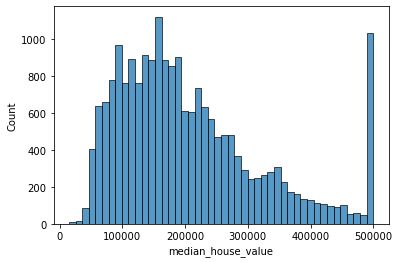

In [5]:
sns.histplot(df_original.median_house_value)

The distribution has a long tail and a considerable amount of outliers 

In [6]:
df = df_original.copy()

Base dataframe with only selected features

In [7]:
base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df = df[base]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


Q1 : Finding missing values

In [8]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Q2: The median for the population variable

In [9]:
df.population.describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

## Setting up the validation framework

Shuffling the dataset and splitting it into training, validation and testing sets.

In [10]:
n = len(df)
idx = np.arange(n)
idx

array([    0,     1,     2, ..., 20637, 20638, 20639])

In [11]:
np.random.seed(42)
np.random.shuffle(idx)

In [12]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n_val, n_test, n_train

(4128, 4128, 12384)

In [13]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [16]:
X_train = df_train.drop("median_house_value", axis=1)
X_val = df_val.drop("median_house_value", axis=1)
X_test = df_test.drop("median_house_value", axis=1)

Q3 : Dealing with missing values

In [17]:
X_train.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
dtype: int64

In [18]:
X_train_mean = X_train.copy()
X_train_zeros = X_train.copy()

In [19]:
X_train_mean = X_train_mean.fillna(X_train_mean.total_bedrooms.mean()).values

In [20]:
X_train_zeros = X_train_zeros.fillna(0).values

## Train linear regression with mean and zero NaN imputation

In [21]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [22]:
w0m, wm = train_linear_regression(X_train_mean, y_train)

In [23]:
w0z, wz = train_linear_regression(X_train_zeros, y_train)

In [24]:
y_pred_m = w0m + X_val.dot(wm)
y_pred_z = w0z + X_val.dot(wz)

The predictions for both mean and zero NaN imputation are very similar.

<AxesSubplot:ylabel='Count'>

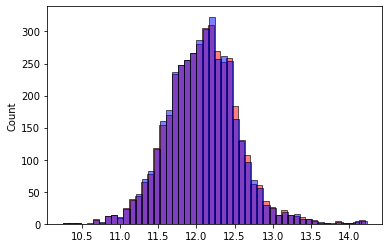

In [25]:
sns.histplot(y_pred_z, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred_m, color='blue', alpha=0.5, bins=50)

If we compare the RSME of both approaches:

In [26]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [27]:
score_m = round(rmse(y_val, y_pred_m), 2)

In [28]:
score_z = round(rmse(y_val, y_pred_z), 2)

In [29]:
score_m, score_z

(0.33, 0.33)

## Train a linear regression with regularization

In [30]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [31]:
list = []
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0zr, wzr = train_linear_regression_reg(X_train_zeros, y_train, r=r)
    y_pred_w0zr = w0zr + X_val.dot(wzr)
    
    score = rmse(y_val, y_pred_w0zr)
    list.append(score)
    
    print(r, score)
print("Smallest RMSE: ", min(list))

0 0.32953303652326227
1e-06 0.3295330361648658
0.0001 0.32953300096949284
0.001 0.32953270386682265
0.01 0.3295319365994547
0.1 0.32969472053908516
1 0.33378872200079446
5 0.3392485345503635
10 0.3406063807810136
Smallest RMSE:  0.3295319365994547


Q4 : Best rmse = 0.3295319365994547, r = 0.01

## Use different random seeds to split data

In [32]:
n = len(df)
idx = np.arange(n)
                
n_val = int(n * 0.20)
n_test = int(n * 0.20)
n_train = n - n_val - n_test

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []                
for seed in seeds:
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
        
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    X_train = df_train.drop("median_house_value", axis=1)
    X_val = df_val.drop("median_house_value", axis=1)
    X_test = df_test.drop("median_house_value", axis=1)
    
    X_train = X_train.fillna(0).values
    
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
    scores.append(score)
print(scores)

[0.3387287407762365, 0.33923295332629866, 0.34851861546923335, 0.34202731114897167, 0.3478926851729838, 0.34396691286260983, 0.34894467550562974, 0.34012580956222765, 0.34083985870816563, 0.3377073792679372]


Standard deviation of scores given different random seeds:

In [33]:
std = round(np.std(scores),4)
std

0.0041

## Testing the best model

Q6 : RMSE of the best model with random seed 9 and r = 0.001

In [35]:
n = len(df)
idx = np.arange(n)
                
n_val = int(n * 0.20)
n_test = int(n * 0.20)
n_train = n - n_val - n_test

np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)  

X_train = df_train.drop("median_house_value", axis=1)
X_test = df_test.drop("median_house_value", axis=1)

X_train = X_train.fillna(0).values

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)
round(score,2)

0.35